In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
import argparse
import numpy as np
import pandas as pd
import random as rn
import tensorflow as tf
import keras.layers as L
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from keras import backend as K
from keras.models import load_model,Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.preprocessing import sequence
from keras.utils.data_utils import Sequence
from keras.regularizers import l2

import matplotlib.pyplot as plt
import warnings
%matplotlib inline

In [ ]:
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
seed_num = 913
np.random.seed(seed_num)
rn.seed(seed_num)
tf.random.set_seed(seed_num)

In [ ]:
final_data = pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/model_data.csv')

In [ ]:
gu = pd.read_excel('./gdrive/My Drive/빅콘 대상팀/data/지역데이터/구_동.xlsx')
gs = pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/all_amt.csv',parse_dates=['STD_YMD'])
gs = pd.concat([gs.iloc[:,[0,1]],gs.filter(like='GS')],axis=1)
gs = pd.merge(gs,gu,on='HDONG_NM')
gs['CITY'] = gs['HDONG_GU'].apply(lambda x: x[0:2])
gs_seoul = gs.query('CITY == "서울" & STD_YMD > "2020"')

gs_eat = gs_seoul.iloc[:,[0,1,3]].sort_values(['HDONG_NM','STD_YMD'])
gs_snack = gs_seoul.iloc[:,[0,1,4]].sort_values(['HDONG_NM','STD_YMD'])
gs_drink = gs_seoul.iloc[:,[0,1,5]].sort_values(['HDONG_NM','STD_YMD'])

In [ ]:
# final data 여러가지 시도
#final_data2= final_data.drop(['holiday','event'],axis=1) #binary 변수 빼기
#final_data3= final_data.drop(['holiday','event','COVID_CNT','covid_p1'],axis=1) 
final_data4 = final_data.drop(['COVID_CNT','covid_p1','sc_m1','cj_m1','covid_p1','최저기온','최고기온','일강수량'],axis=1) #최종사용데이터
#final_data5 = final_data.drop(['holiday','event','COVID_CNT','covid_p1','sc_m1','cj_m1','covid_p1','기온','최저기온','최고기온','일강수량','일교차','dust'],axis=1)
#final_weather = final_data.loc[:,['STD_YMD','HDONG_NM','기온','최저기온','최고기온','일강수량','일교차','dust']]

In [ ]:
final_data4.head()

,STD_YMD,HDONG_NM,cj_0,sc_0,sk_0,기온,일교차,dust
0,2020-02-01,공릉1동,391.0,109333.0,34575.798750,1.5,7.4,54
1,2020-02-01,공릉2동,366.0,72233.0,32178.180000,1.5,7.4,54
2,2020-02-01,광희동,428.0,316600.0,37139.792917,1.5,7.4,54
3,2020-02-01,다산동,452.0,540517.0,13473.501667,1.5,7.4,54
4,2020-02-01,동화동,205.0,73361.0,6103.977500,1.5,7.4,54


In [ ]:
def minmax_scalar(X):
  idx = X.index
  col = X.columns

  scalar = MinMaxScaler()
  scaled_X = pd.DataFrame(scalar.fit_transform(X))
  scaled_X.index = idx
  scaled_X.columns = col

  return scaled_X

In [ ]:
def split_xy(dataset, time_steps, y_column):

  x, y = list(), list()
  for i in range(len(dataset)):
    x_end_number = i + time_steps
    y_end_number = x_end_number + y_column

    if y_end_number > len(dataset):
      break
    tmp_x = np.array(dataset)[i:x_end_number, :]
    tmp_y = np.array(dataset)[x_end_number:y_end_number, -1]
    x.append(tmp_x)
    y.append(tmp_y)
  return np.array(x), np.array(y)


In [ ]:
def build_data(data,dong,cat):

  X = data.query('HDONG_NM==@dong').reset_index(drop=True)
  
  if cat == "식사":
    eat = gs_eat.query('HDONG_NM==@dong').reset_index(drop=True)
    #X['self_m7'] = eat['GS_식사'].shift(7)
    X['y'] = eat['GS_식사']
  elif cat == "간식":
    snack = gs_snack.query('HDONG_NM==@dong').reset_index(drop=True)
    #X['self_m7'] = snack['GS_간식'].shift(7)
    X['y'] = snack['GS_간식']
  elif cat == "마실거리":
    drink = gs_drink.query('HDONG_NM==@dong').reset_index(drop=True)
    #X['self_m7'] = drink['GS_마실거리'].shift(7)
    X['y'] = drink['GS_마실거리']
  
  X.index = X['STD_YMD']
  del X['STD_YMD'],X['HDONG_NM']

  return X

In [ ]:
def data_pipeline(data, dong, cat, time_steps, y_columns):
  data = build_data(data,dong,cat)
  
  #y = data['y']
  #del data['y']
  min = data['y'].min()
  max = data['y'].max()

  X = minmax_scalar(data)
  #Xy = pd.concat([X,y],axis=1)
  Xy = X.dropna()
  
  X,y = split_xy(Xy,time_steps,y_columns)

  X_train, y_train = X[:-7],y[:-7]
  X_test, y_test = X[-7:],y[-7:]

  X_test=X_test.reshape(-1,time_steps,X_train.shape[2])
  y_test=y_test.reshape(-1,y_columns)


  return X_train,y_train,X_test,y_test,min,max

In [ ]:
# 모델 load
def import_model(path):
    K.clear_session()
    config = tf.compat.v1.ConfigProto(allow_soft_placement=True, log_device_placement=False)
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))
    model = load_model(path)
    model_with_attention = Model(model.inputs, model.outputs +\
                                              [model.get_layer(name='softmax_1').output,\
                                               model.get_layer(name='beta_dense_0').output])
    return model, model_with_attention

In [ ]:
# get models parameters for interpretation
def get_model_parameters(model):
    class ModelParameters:
        def __init__(self):
            self.output_weights = None     
            self.bias = None

    params = ModelParameters()
    params.output_weights, params.bias = model.get_layer(name='time_distributed_out').get_weights()

    return params

# **1. 모델 변수/시점 별 해석 (graph ver.)**

In [ ]:
# 모델에서 layer output을 통해 해석가능한 matrix형태로 계산하는 함수
def get_weights(d,c):
  path = "./gdrive/My Drive/빅콘 대상팀/분석 code/RETAIN/models_weather_shifting/{}_{}_retain.hdf5".format(d,c)
  model, model_with_attention = import_model(path)

  X_train,y_train,X_test,y_test,_,_ = data_pipeline(final_data4,d,c,7,1)

  proba,alpha,beta=model_with_attention.predict_on_batch(X_test)

  W=get_model_parameters(model).output_weights
  W=W.reshape(-1,1,7)

  w = W*alpha*beta
  return w


In [ ]:
#원하는 날짜의 index를 넣으면 해당 날짜 예측 해석 가능
def inter_plot(d,c,date):
  w = get_weights(d,c)
  w = w[date,:,:]

  fig, ax = plt.subplots(figsize=(13,6))
  ax.plot(w[:,0])
  ax.plot(w[:,1])
  ax.plot(w[:,2])
  ax.plot(w[:,3])
  ax.plot(w[:,4])
  ax.plot(w[:,5])
  ax.plot(w[:,6])
  ax.set_xlabel('예측에 사용된 날짜', fontsize=13)
  ax.set_xticklabels(['8일전','7일전','6일전','5일전','4일전','3일전','2일전','1일전'])
  plt.title(d +" " + c,fontsize=20)
  plt.legend(['cj유통','신한카드 유통업','유동인구','기온','일교차','미세먼지','판매량'])

In [ ]:
# 예측된 날짜들에 대한 변수기여도의 평균을 시각화
def inter_plot_mean(d,c):
  w = get_weights(d,c)
  w = w.mean(axis=0)
  fig, ax = plt.subplots(figsize=(10,6))
  ax.plot(w)
  ax.set_xlabel('예측에 사용된 날짜', fontsize=13)
  ax.set_xticklabels(['8일전','7일전','6일전','5일전','4일전','3일전','2일전','1일전'])
  plt.title(d +" " + c + " sequence 해석",fontsize=20)
  plt.legend(['cj유통','신한카드 유통업','유동인구','기온','일교차','미세먼지','판매량'])
      
             #loc='lower center',bbox_to_anchor=(0.5, 0.9),ncol=7,fontsize=12)
  

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


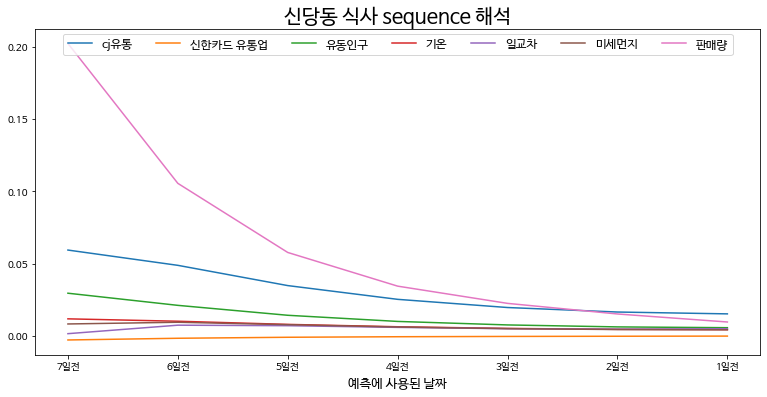

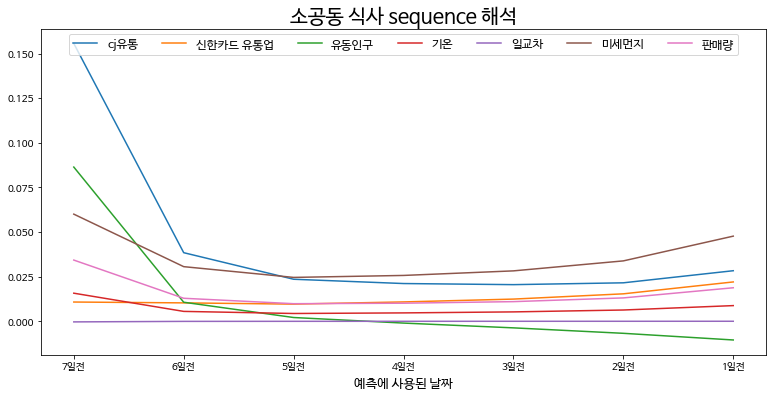

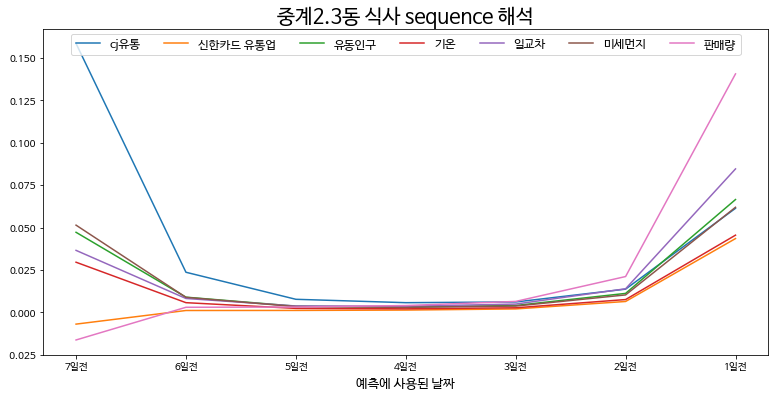

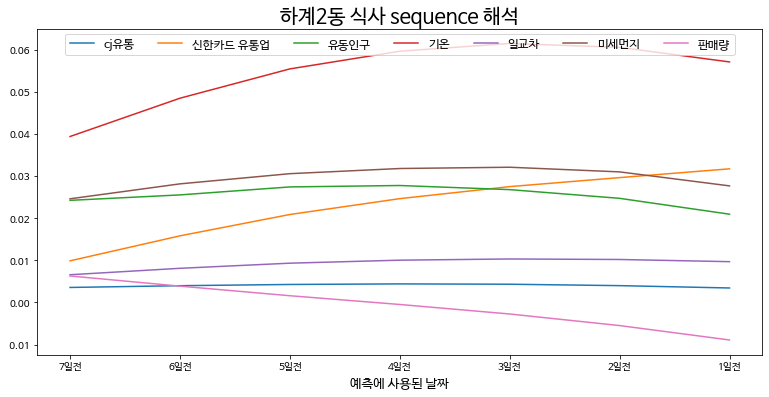

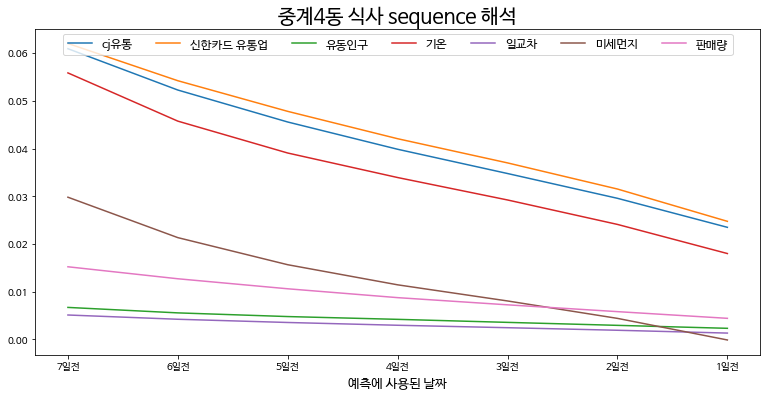

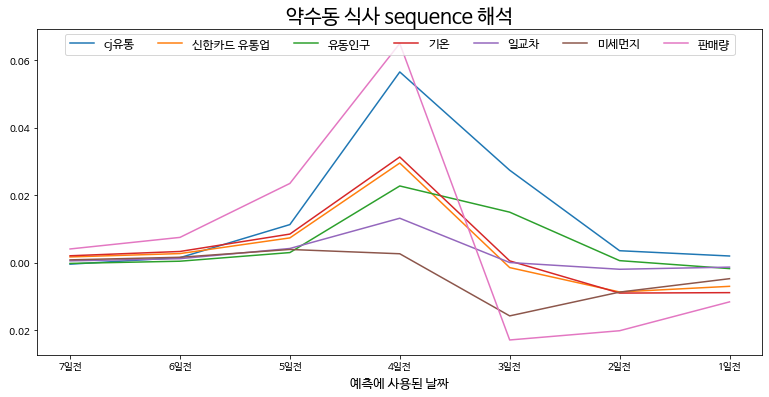

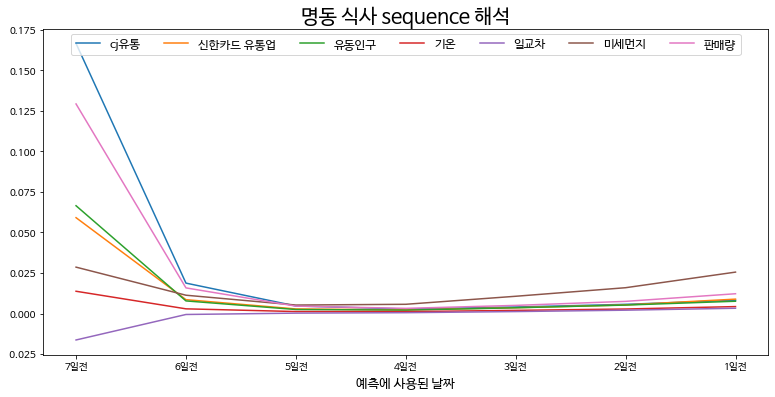

In [ ]:
bad = ['신당동', '소공동', '중계2.3동', '하계2동', '중계4동','약수동','명동']
for d in bad: 
  inter_plot_mean(d,'식사')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


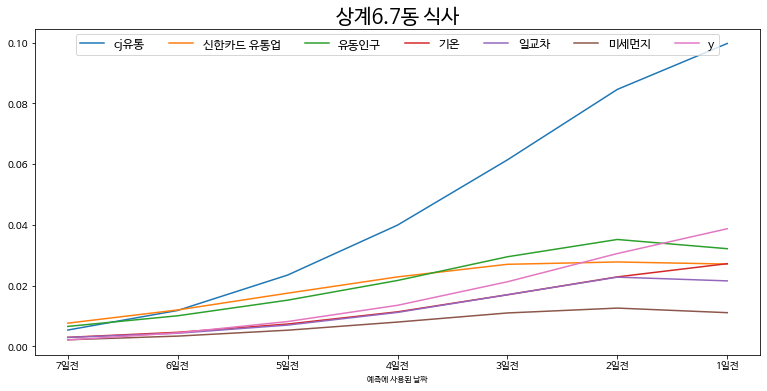

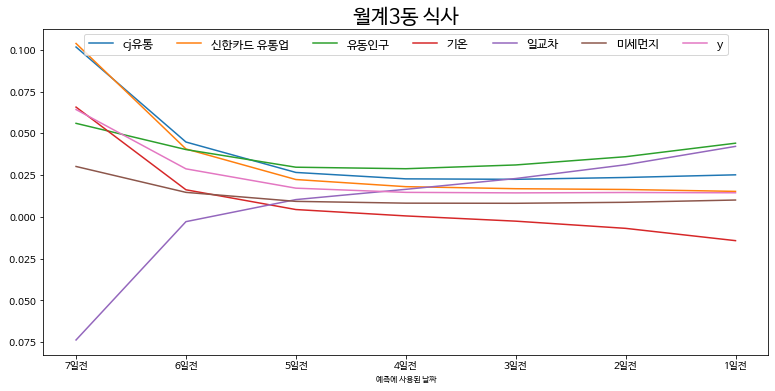

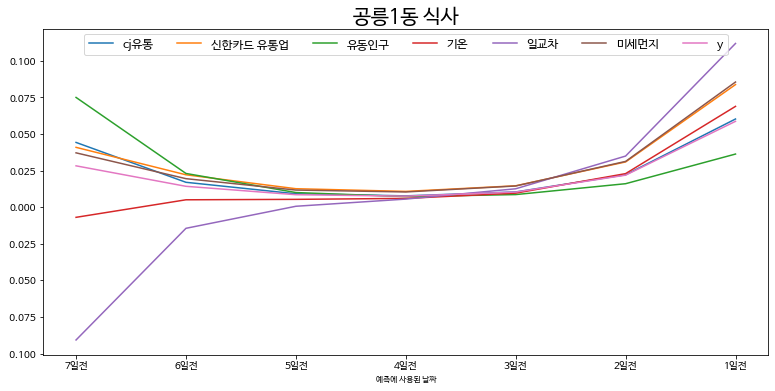

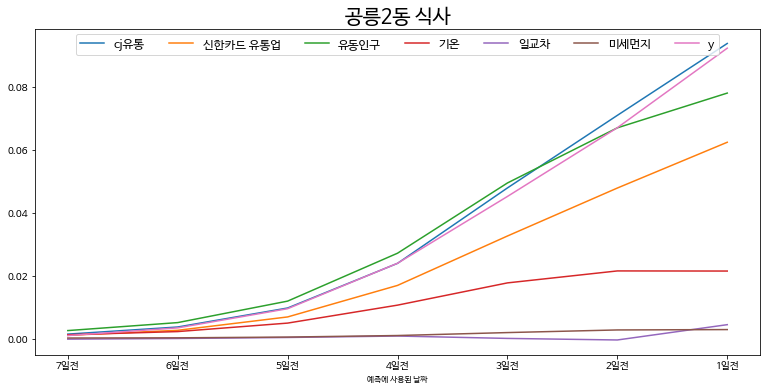

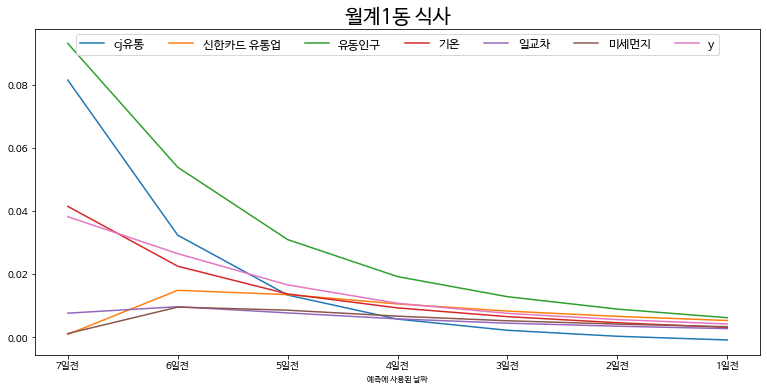

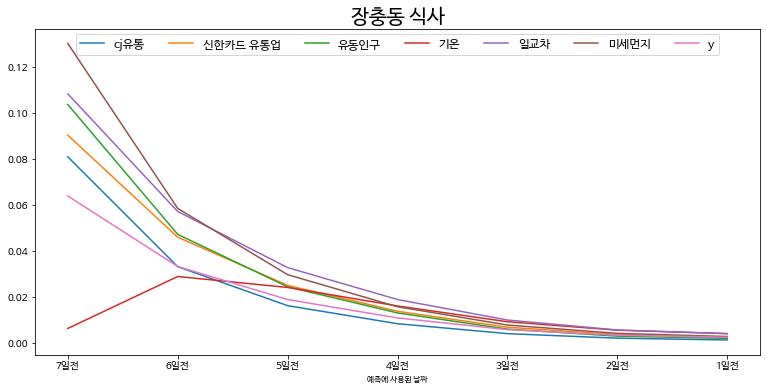

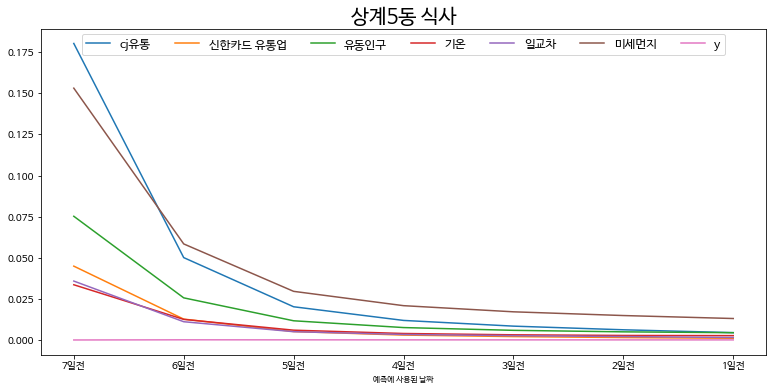

In [ ]:
good = ['상계6.7동', '월계3동', '공릉1동', '공릉2동', '월계1동', '장충동', '상계5동']
for d in good: 
  inter_plot_mean(d,'식사')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


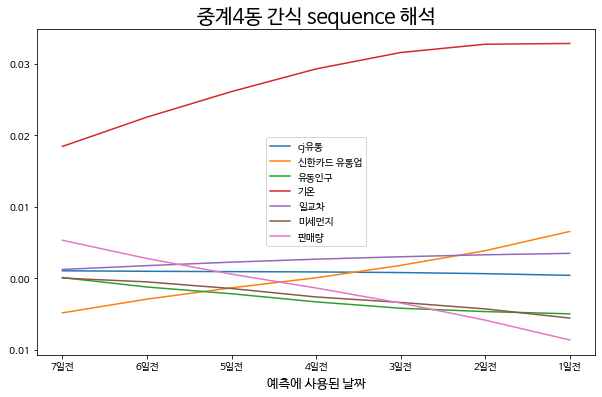

In [ ]:
inter_plot_mean('중계4동','간식')

# **2. 모든동 기여도 heatmap**

In [ ]:
dong = list(gu.query('HDONG_GU =="서울 노원구"').HDONG_NM.unique())+list(gu.query('HDONG_GU =="서울 중구"').HDONG_NM.unique())
dong.remove('상계8동')
cat = ['식사','간식','마실거리']

In [ ]:
def get_weights_summary(cat,dong):
  W=[]
  for d in dong:
    if d =='상계8동':
      continue
    w = get_weights(d,cat)
    w = w.mean(axis=0).sum(axis=0).tolist()
    W.append(w)

  W = pd.DataFrame(np.array(W))
  W.index = dong
  W.columns = ['cj유통','신한카드 유통업','유동인구','기온','일교차','미세먼지','판매량']

  return W

In [ ]:
bottom10 = ['광희동','을지로동','소공동','명동','회현동','필동','하계1동','장충동','다산동','월계1동']
drink = get_weights_summary('마실거리',dong)
eat = get_weights_summary('식사',dong)
snack = get_weights_summary('간식',dong)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


Text(0.5, 1.0, '간식')

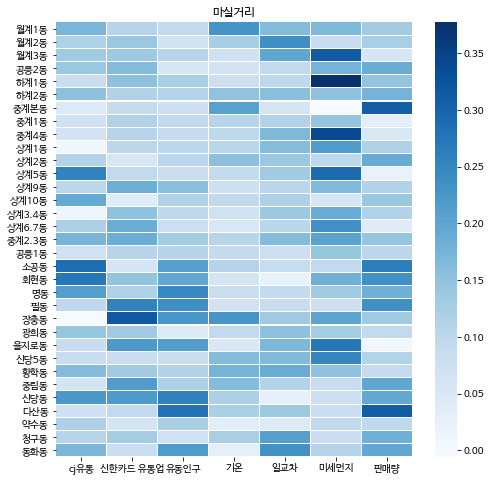

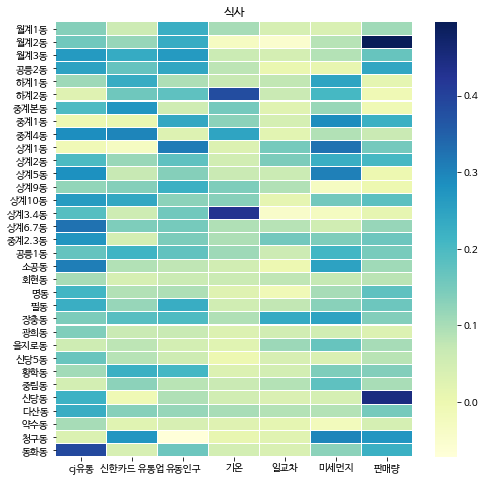

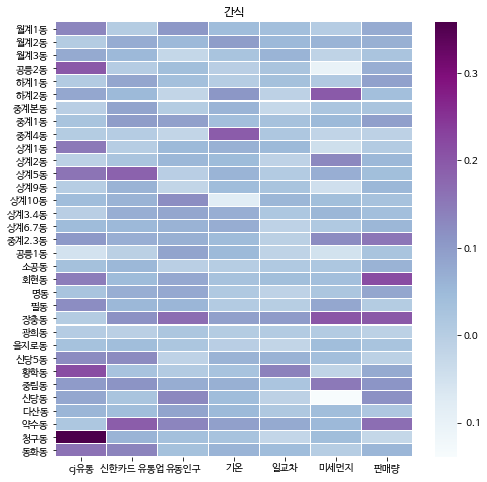

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,8))
sns.heatmap(drink,linewidths=0.1,cmap='Blues')
plt.title('마실거리')

plt.figure(figsize=(8,8))
sns.heatmap(eat,linewidths=0.1,cmap='YlGnBu')
plt.title('식사')

plt.figure(figsize=(8,8))
sns.heatmap(snack,linewidths=0.1, cmap = 'BuPu')
plt.title('간식')


Text(0.5, 1.0, '간식')

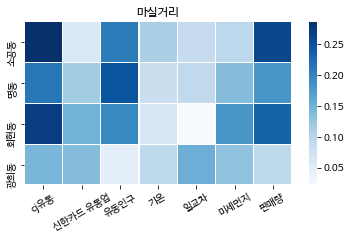

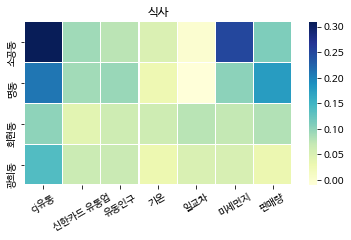

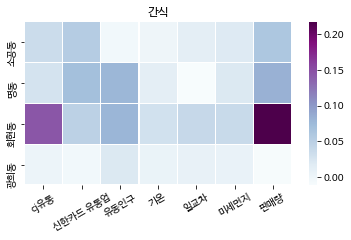

In [ ]:
#업무지구
work = ['소공동','명동','회현동','광희동']
plt.figure(figsize=(6,3))
sns.heatmap(drink.loc[work,:],linewidths=0.1,cmap='Blues')
plt.xticks(rotation=30)
plt.title('마실거리')

plt.figure(figsize=(6,3))
sns.heatmap(eat.loc[work,:],linewidths=0.1,cmap='YlGnBu')
plt.xticks(rotation=30)
plt.title('식사')

plt.figure(figsize=(6,3))
sns.heatmap(snack.loc[work,:],linewidths=0.1, cmap = 'BuPu')
plt.xticks(rotation=30)
plt.title('간식')


Text(0.5, 1.0, '간식')

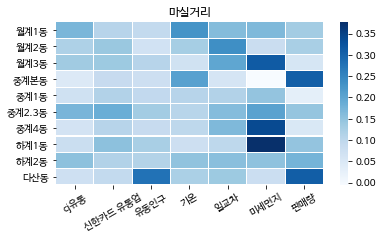

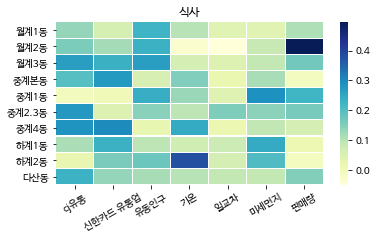

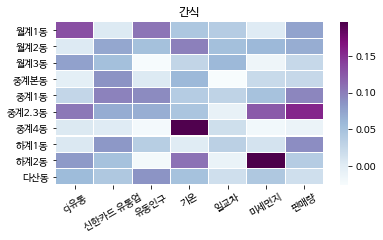

In [ ]:
#주거지구
live = ['월계1동','월계2동','월계3동','중계본동','중계1동','중계2.3동','중계4동','하계1동','하계2동','다산동']
plt.figure(figsize=(6,3))
sns.heatmap(drink.loc[live,:],linewidths=0.1,cmap='Blues')
plt.xticks(rotation=30)
plt.title('마실거리')

plt.figure(figsize=(6,3))
sns.heatmap(eat.loc[live,:],linewidths=0.1,cmap='YlGnBu')
plt.xticks(rotation=30)
plt.title('식사')

plt.figure(figsize=(6,3))
sns.heatmap(snack.loc[live,:],linewidths=0.1, cmap = 'BuPu')
plt.xticks(rotation=30)
plt.title('간식')

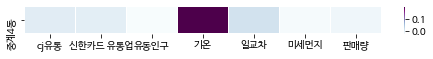

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,0.5))
sns.heatmap(snack.loc[['중계4동'],:],linewidths=0.1, cmap = 'BuPu')

# **3. 전체 동별 모델 평가**

In [ ]:
warnings.filterwarnings("ignore")

MAE_RETAIN = []
MSE_RETAIN=[]
RMSE_RETAIN=[]
MSLE_RETAIN = []
RMSLE_RETAIN=[]
for j,c in enumerate(cat):
  for i,d in enumerate(dong):
    if d =="상계8동":
      continue
    #path = "./gdrive/My Drive/빅콘 대상팀/분석 code/RETAIN/models/{}_{}_retain.hdf5".format(d,c)
    path = "./gdrive/My Drive/빅콘 대상팀/분석 code/RETAIN/models_weather_shifting/{}_{}_retain.hdf5".format(d,c)
    model, model_with_attention = import_model(path)

    X_train,y_train,X_test,y_test,min,max = data_pipeline(final_data4,d,c,7,1)

    y_pred = model.predict_on_batch(X_test)

    y_test = y_test.reshape(1,-1) #* (max-min) + min
    y_pred = y_pred.reshape(1,-1) #* (max-min) + min

    mae =  mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    msle= mean_squared_log_error(y_test+1, y_pred+1)
    rmsle = np.sqrt(mean_squared_log_error(y_test+1, y_pred+1))
    
    print("동:{}, 카테고리:{}, mse:{} rmse:{} rmsle:{}".format(d,c,mse,rmse,rmsle))

    MAE_RETAIN.append(mae)
    MSE_RETAIN.append(mse)
    RMSE_RETAIN.append(rmse)
    MSLE_RETAIN.append(msle)
    RMSLE_RETAIN.append(rmsle)

동:월계1동, 카테고리:식사, mse:0.038422217759151514 rmse:0.1960158609887259 rmsle:0.07602805889925343
동:월계2동, 카테고리:식사, mse:0.01967806192942701 rmse:0.14027851556609447 rmsle:0.05524694154611326
동:월계3동, 카테고리:식사, mse:0.025645288305217267 rmse:0.16014146341662194 rmsle:0.0578768624065797
동:공릉2동, 카테고리:식사, mse:0.023338456749063857 rmse:0.15276929255928318 rmsle:0.0550631763924043
동:하계1동, 카테고리:식사, mse:0.013539108696335076 rmse:0.11635767570871754 rmsle:0.04474159703186986
동:하계2동, 카테고리:식사, mse:0.043262892271920025 rmse:0.20799733717507066 rmsle:0.07885798845881763
동:중계본동, 카테고리:식사, mse:0.027204330073001104 rmse:0.16493735196431736 rmsle:0.06363150295199661
동:중계1동, 카테고리:식사, mse:0.03587567930621337 rmse:0.18940876248530153 rmsle:0.06944994526316824
동:중계4동, 카테고리:식사, mse:0.017210549484833138 rmse:0.13118898385471678 rmsle:0.04903944767977711
동:상계1동, 카테고리:식사, mse:0.006170657934835508 rmse:0.07855353546999339 rmsle:0.03151911576600512
동:상계2동, 카테고리:식사, mse:0.012920070138021258 rmse:0.1136664864329907 rmsle:0.0

In [ ]:
#dong.remove('상계8동')
n=len(dong)
result_retain = pd.DataFrame({'dong':dong,
                       'mse_eat':MSE_RETAIN[:n],
                       'mse_snack':MSE_RETAIN[n:len(MSE_RETAIN)-n],
                       'mse_drink':MSE_RETAIN[len(MSE_RETAIN)-n:],
                       'rmse_eat':RMSE_RETAIN[:n],
                       'rmse_snack':RMSE_RETAIN[n:len(RMSE_RETAIN)-n],
                       'rmse_drink':RMSE_RETAIN[len(RMSE_RETAIN)-n:],
                       'mae_eat':MAE_RETAIN[:n],
                       'mae_snack':MAE_RETAIN[n:len(MAE_RETAIN)-n],
                       'mae_drink':MAE_RETAIN[len(MAE_RETAIN)-n:],
                       'msle_eat':MSLE_RETAIN[:n],
                       'msle_snack':MSLE_RETAIN[n:len(MSLE_RETAIN)-n],
                       'msle_drink':MSLE_RETAIN[len(MSLE_RETAIN)-n:],
                       'rmsle_eat':RMSLE_RETAIN[:n],
                       'rmsle_snack':RMSLE_RETAIN[n:len(RMSLE_RETAIN)-n],
                       'rmsle_drink':RMSLE_RETAIN[len(RMSLE_RETAIN)-n:]}).reset_index(drop=True)


In [ ]:
result_retain

,dong,mse_eat,mse_snack,mse_drink,rmse_eat,rmse_snack,rmse_drink,mae_eat,mae_snack,mae_drink,msle_eat,msle_snack,msle_drink,rmsle_eat,rmsle_snack,rmsle_drink
0,월계1동,0.038422,0.001761,0.002295,0.196016,0.041965,0.047906,0.166772,0.034823,0.038138,0.005780,0.000350,0.000324,0.076028,0.018701,0.018006
1,월계2동,0.019678,0.004253,0.023343,0.140279,0.065215,0.152785,0.126576,0.060095,0.120151,0.003052,0.000773,0.003356,0.055247,0.027810,0.057931
2,월계3동,0.025645,0.002173,0.003390,0.160141,0.046617,0.058222,0.126779,0.041292,0.048617,0.003350,0.000459,0.000474,0.057877,0.021431,0.021773
3,공릉2동,0.023338,0.003412,0.009595,0.152769,0.058410,0.097952,0.123507,0.055151,0.076698,0.003032,0.000698,0.001277,0.055063,0.026424,0.035735
4,하계1동,0.013539,0.006529,0.020120,0.116358,0.080801,0.141846,0.103832,0.066013,0.131204,0.002002,0.001262,0.002828,0.044742,0.035532,0.053183
5,하계2동,0.043263,0.009342,0.001601,0.207997,0.096653,0.040010,0.184052,0.086846,0.029462,0.006219,0.001637,0.000210,0.078858,0.040464,0.014493
6,중계본동,0.027204,0.000142,0.007010,0.164937,0.011902,0.083724,0.133138,0.009931,0.073049,0.004049,0.000029,0.001051,0.063632,0.005360,0.032412
7,중계1동,0.035876,0.008041,0.027095,0.189409,0.089672,0.164606,0.138433,0.076197,0.142345,0.004823,0.001401,0.003796,0.069450,0.037433,0.061616
8,중계4동,0.017211,0.002732,0.037168,0.131189,0.052267,0.192791,0.089893,0.035600,0.159433,0.002405,0.000578,0.005502,0.049039,0.024035,0.074176
9,상계1동,0.006171,0.001788,0.014858,0.078554,0.042290,0.121893,0.072313,0.035193,0.092695,0.000993,0.000397,0.002029,0.031519,0.019932,0.045045


In [ ]:
result_retain.filter(like='eat').mean(axis=0)

mse_eat      0.016962
rmse_eat     0.120878
mae_eat      0.098129
msle_eat     0.002588
rmsle_eat    0.047388
dtype: float64

In [ ]:
result_retain.filter(like='snack').mean(axis=0)

mse_snack      0.006033
rmse_snack     0.067909
mae_snack      0.056216
msle_snack     0.001080
rmsle_snack    0.029352
dtype: float64

In [ ]:
result_retain.filter(like='drink').mean(axis=0)

mse_drink      0.013238
rmse_drink     0.106190
mae_drink      0.088633
msle_drink     0.001858
rmsle_drink    0.039680
dtype: float64

## 1) 전주 동요일 예측이 잘 안되는 동 예측

In [ ]:
final_data4.query('HDONG_NM=="신당동"').head(20)

,STD_YMD,HDONG_NM,cj_0,sc_0,sk_0,기온,일교차,dust
16,2020-02-01,신당동,369.0,33299.0,17146.106667,1.5,7.4,54
50,2020-02-02,신당동,202.0,26620.0,13985.341667,-0.4,5.9,16
84,2020-02-03,신당동,3039.0,40127.0,22425.279167,-1.6,9.9,16
118,2020-02-04,신당동,2187.0,43393.0,22511.385833,-8.3,6.1,11
152,2020-02-05,신당동,2166.0,38903.0,22327.886250,-6.4,12.2,21
186,2020-02-06,신당동,1852.0,38460.0,22071.203750,-1.7,9.4,24
220,2020-02-07,신당동,1762.0,37555.0,23032.489583,-0.1,6.0,29
254,2020-02-08,신당동,382.0,31177.0,16874.067500,-0.5,9.7,25
288,2020-02-09,신당동,105.0,25011.0,14044.610000,4.0,10.3,31
322,2020-02-10,신당동,3208.0,36754.0,22584.927500,6.8,15.1,35


In [ ]:
gs_eat.query('HDONG_NM=="신당동"').head(20)

,STD_YMD,HDONG_NM,GS_식사
8045,2020-02-01,신당동,40.6080
8046,2020-02-02,신당동,35.6950
8047,2020-02-03,신당동,55.2900
8048,2020-02-04,신당동,61.9530
8049,2020-02-05,신당동,61.1900
8050,2020-02-06,신당동,62.4860
8051,2020-02-07,신당동,58.3050
8052,2020-02-08,신당동,41.9190
8053,2020-02-09,신당동,34.5000
8054,2020-02-10,신당동,55.9290


In [ ]:
bad = ['신당동', '소공동', '중계2.3동', '하계2동', '중계4동','약수동','명동']
cat = ['식사','간식','마실거리']

In [ ]:
warnings.filterwarnings("ignore")
Y=[]
for j,c in enumerate(cat):
  for i,d in enumerate(bad):
    if d =="상계8동":
      continue
    #path = "./gdrive/My Drive/빅콘 대상팀/분석 code/RETAIN/models/{}_{}_retain.hdf5".format(d,c)
    path = "./gdrive/My Drive/빅콘 대상팀/분석 code/RETAIN/models_weather_shifting/{}_{}_retain.hdf5".format(d,c)
    model, model_with_attention = import_model(path)

    X_train,y_train,X_test,y_test,min,max = data_pipeline(final_data4,d,c,7,1)
    #X_test = X_train[58:65]
    #y_test = y_train[58:65]

    y_pred = model.predict_on_batch(X_test)

    y_test = y_test.reshape(1,-1) * (max-min) + min
    y_pred = y_pred.reshape(1,-1) * (max-min) + min

    print


    Y.append(y_pred)

In [ ]:
Y=np.array(Y).reshape(-1,7)
Y=pd.DataFrame(Y)
Y.index = bad*3
Y['cat'] = ['식사']*7 + ['간식']*7 + ['마실거리']*7

In [ ]:
Y=Y.reset_index()
Y

,index,0,1,2,3,4,5,6,cat
0,신당동,57.792564,56.778877,57.828964,56.032341,52.408798,46.561638,49.398014,식사
1,소공동,35.320370,37.883114,38.276867,38.864105,36.895599,23.315727,21.741699,식사
2,중계2.3동,49.990902,53.502811,55.093628,54.062599,57.802254,47.641628,43.334045,식사
3,하계2동,48.892029,49.667618,49.747139,49.750717,49.927643,50.133499,50.540447,식사
4,중계4동,31.828243,32.527023,33.134232,33.323738,33.197578,32.967827,32.997990,식사
5,약수동,40.813438,39.489338,35.740761,38.525719,41.767498,37.428734,39.136589,식사
6,명동,32.519890,34.983551,33.495880,34.147587,30.518175,18.326414,12.886963,식사
7,신당동,34.667648,36.182732,37.555962,37.094967,36.577789,29.480843,21.042952,간식
8,소공동,25.505991,27.326427,29.134478,29.201738,31.202036,22.427504,17.127579,간식
9,중계2.3동,30.531103,33.373821,33.170444,34.474442,36.466110,40.112713,33.943069,간식


In [ ]:
#Y.to_csv('./gdrive/My Drive/빅콘 대상팀/data/result/0525_0531_retain_full_training.csv',index=False)

## 2) 전주 동요일 예측이 잘되는 동 예측


In [ ]:
good = ['상계6.7동', '월계3동', '공릉1동', '공릉2동', '월계1동', '장충동', '상계5동']

In [ ]:
warnings.filterwarnings("ignore")
Y_good=[]
for j,c in enumerate(cat):
  for i,d in enumerate(Y_good):
    if d =="상계8동":
      continue
    #path = "./gdrive/My Drive/빅콘 대상팀/분석 code/RETAIN/models/{}_{}_retain.hdf5".format(d,c)
    path = "./gdrive/My Drive/빅콘 대상팀/분석 code/RETAIN/models_weather_shifting/{}_{}_retain.hdf5".format(d,c)
    model, model_with_attention = import_model(path)

    X_train,y_train,X_test,y_test,min,max = data_pipeline(final_data4,d,c,7,1)
    #X_test = X_train[58:65]
    #y_test = y_train[58:65]

    y_pred = model.predict_on_batch(X_test)

    y_test = y_test.reshape(1,-1) * (max-min) + min
    y_pred = y_pred.reshape(1,-1) * (max-min) + min

    print


    Y_good.append(y_pred)

In [ ]:
Y_good=np.array(Y_good).reshape(-1,7)
Y_good=pd.DataFrame(Y_good)
Y_good.index = good*3
Y_good['cat'] = ['식사']*7 + ['간식']*7 + ['마실거리']*7

In [ ]:
Y_good=Y_good.reset_index()
Y_good

,index,0,1,2,3,4,5,6,cat
0,상계6.7동,31.787437,32.391575,32.804623,33.236347,33.186615,33.221008,32.403507,식사
1,월계3동,28.568840,28.771103,29.079967,29.043100,28.859360,27.403282,27.452778,식사
2,공릉1동,24.159412,25.085213,25.614613,25.390825,25.360226,22.690184,20.982508,식사
3,공릉2동,27.348883,27.872101,28.011127,28.063805,28.493900,28.326794,28.308483,식사
4,월계1동,27.892496,27.707130,27.955067,28.454039,28.404053,27.408115,26.991219,식사
5,장충동,23.945570,23.805809,25.107101,25.721407,24.646776,22.335865,20.862751,식사
6,상계5동,32.126064,31.611673,32.142635,32.380844,32.300110,31.111473,30.455399,식사
7,상계6.7동,25.296593,26.024445,26.215723,28.335846,30.791409,36.832039,33.040112,간식
8,월계3동,21.929943,22.356457,23.652489,24.632252,26.311253,28.066223,27.302685,간식
9,공릉1동,13.581289,14.148988,14.517937,14.924575,15.045401,14.927317,13.879118,간식


In [ ]:
#Y_good.to_csv('./gdrive/My Drive/빅콘 대상팀/data/result/(good)0525_0531_retain_full_training.csv',index=False)

# **4. 모든 동 예측 값**

In [ ]:
warnings.filterwarnings("ignore")

eat=[]
snack=[]
drink = []

for j,c in enumerate(cat):
  for i,d in enumerate(dong):
    if d =="상계8동":
      continue
    #path = "./gdrive/My Drive/빅콘 대상팀/분석 code/RETAIN/models/{}_{}_retain.hdf5".format(d,c)
    path = "./gdrive/My Drive/빅콘 대상팀/분석 code/RETAIN/models_weather_shifting/{}_{}_retain.hdf5".format(d,c)
    model, model_with_attention = import_model(path)

    X_train,y_train,X_test,y_test,min,max = data_pipeline(final_data4,d,c,7,1)
    #X_test = X_train[58:65]
    #y_test = y_train[58:65]

    y_pred = model.predict_on_batch(X_test)

    y_test = y_test.reshape(1,-1) * (max-min) + min
    y_pred = y_pred.reshape(1,-1) * (max-min) + min
    if cat == '식사':
      eat.append(y_pred)
    elif cat == '간식':
      snack.append(y_pred)
    else:
      drink.append(y_pred)

In [ ]:
#all_result = pd.DataFrame({'동' : dong,
#                            '마실거리': drink,
#                           '식사':eat,
#                           '간식':snack})

In [ ]:
#all_result.to_csv('./gdrive/My Drive/빅콘 대상팀/data/result/(all)0525_0531_retain_full_training.csv',index=False)